In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!unzip "/content/drive/MyDrive/Lab ai brain tumor/dataset.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_1020.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0458.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0504.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0262.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0276.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_1168.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0510.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0538.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_1140.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_1154.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_1183.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_1197.jpg  
  inflating: /content/dataset/dataset/Training/notumor/Tr-no_0289.jpg  
  inflating: 

## Import Needed Package

In [20]:
#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

## Combine dataset ( Images And it labels )

In [21]:
import os
import pandas as pd

train_data_path = '/content/dataset/dataset/Training'

filepaths = []
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path, fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'label')
train_df = pd.concat([Fseries, Lseries], axis = 1)

In [22]:
test_data_path = '/content/dataset/dataset/Testing'

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path, fold)
    if os.path.isdir(f_path):
        filelists = os.listdir(f_path)

        for file in filelists:
            filepaths.append(os.path.join(f_path, file))
            labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths, name = 'filepaths')
Lseries = pd.Series(labels, name = 'label')
test_df = pd.concat([Fseries, Lseries], axis = 1)

##Data Spliting

In [23]:
valid, test = train_test_split(test_df, train_size = 0.5, shuffle = True, random_state = 42)

In [24]:


img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show Images  and Labels

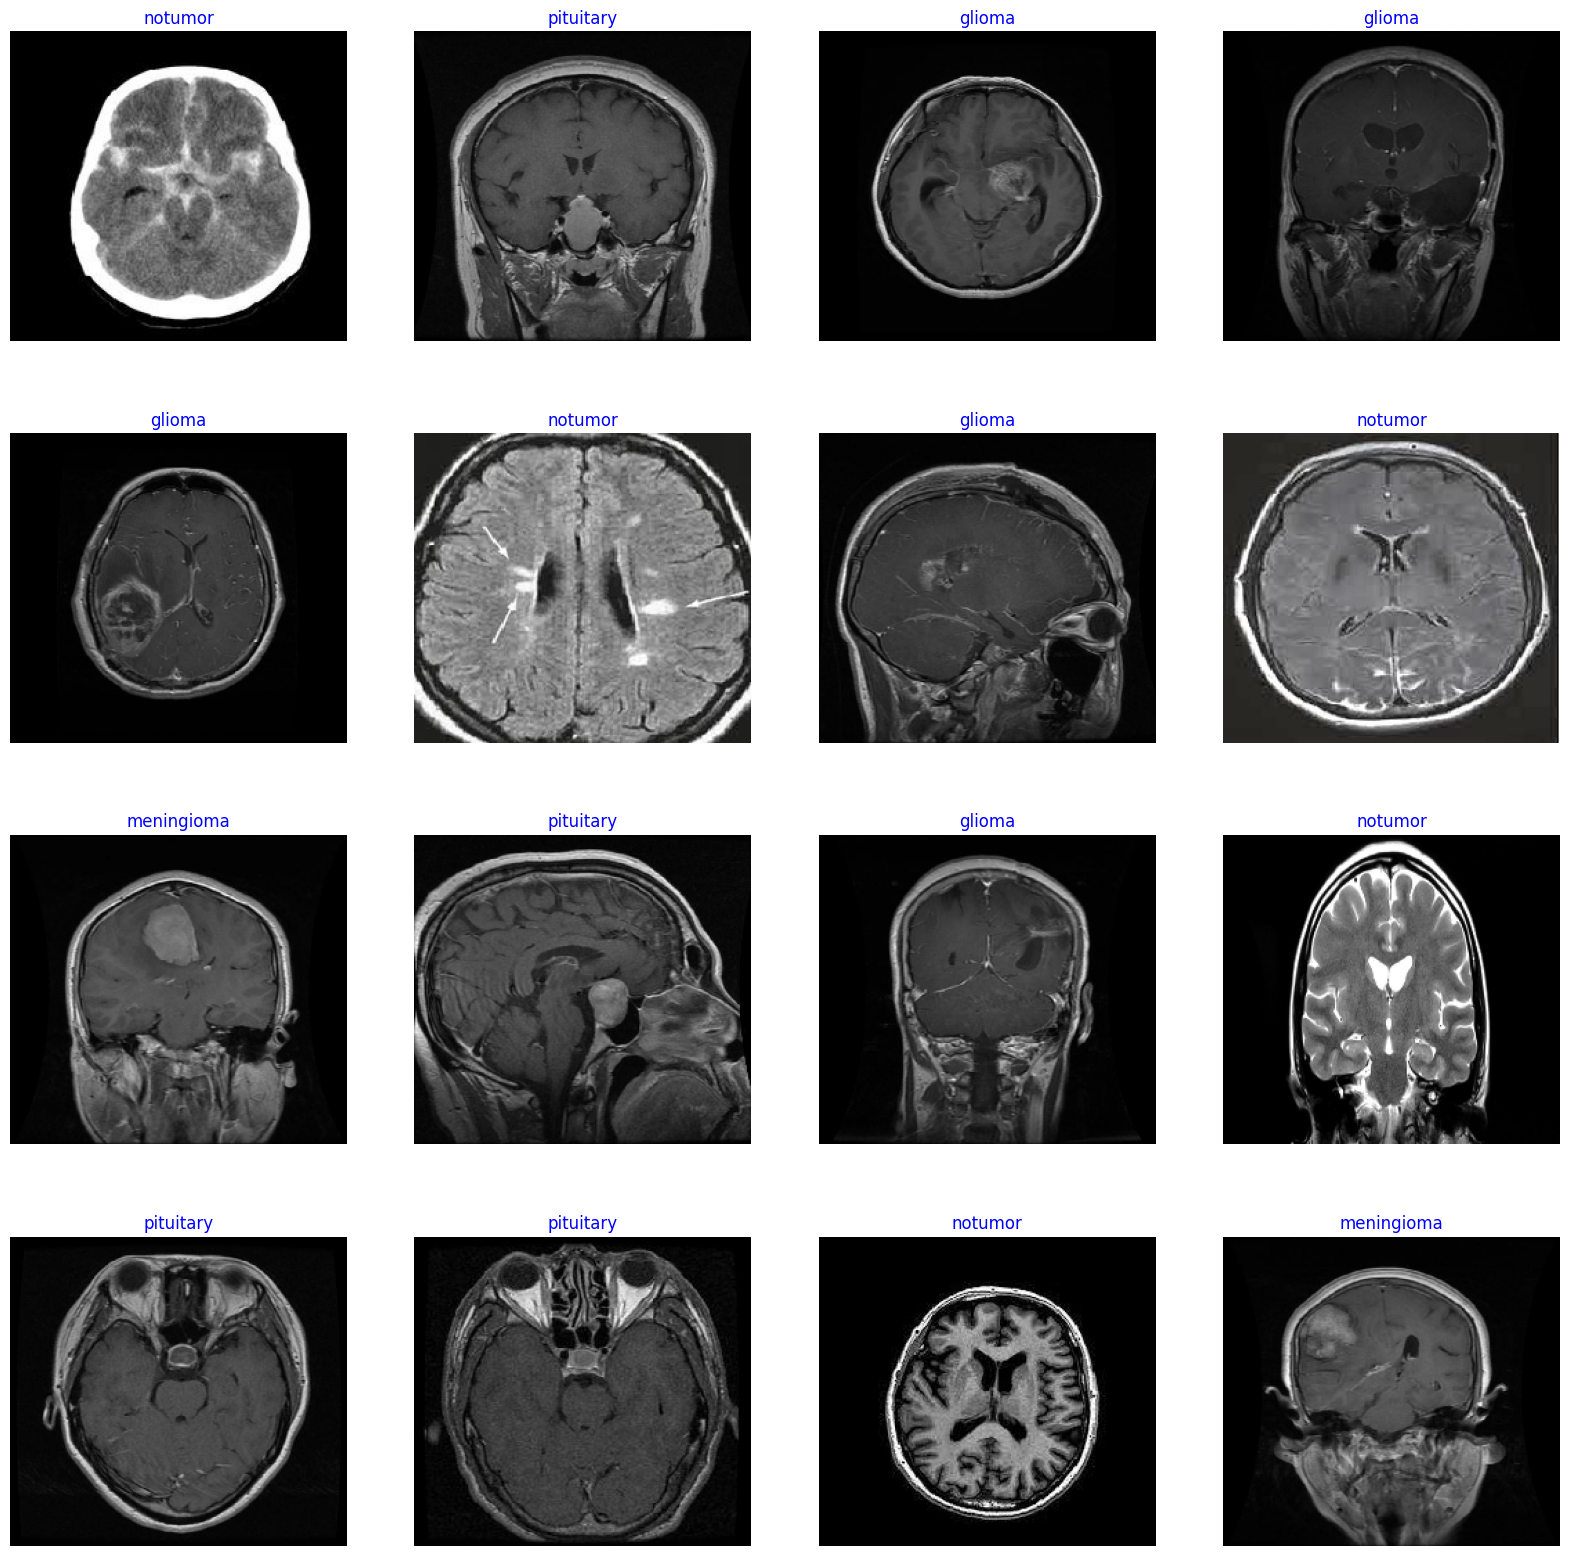

In [25]:
# Show Images and Labels

gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

## Building

In [26]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top = False , weights = 'imagenet',
    input_shape = img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,253,396 (23.85 MB)

 Trainable params: 6,190,228 (23.61 MB)

 Non-trainable params: 63,168 (246.75 KB)

##Training Model

In [27]:
Epochs = 10

history = model.fit(
    train_gen,
    epochs=Epochs,
    verbose=1,
    validation_data=valid_gen,
    shuffle=True
)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 141s 137ms/step - accuracy: 0.5372 - loss: 10.1833 - val_accuracy: 0.3893 - val_loss: 5.5429
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 78ms/step - accuracy: 0.3748 - loss: 5.0252 - val_accuracy: 0.5511 - val_loss: 3.6478
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.5292 - loss: 3.3305 - val_accuracy: 0.6336 - val_loss: 2.4857
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step - accuracy: 0.6025 - loss: 2.3178 - val_accuracy: 0.7008 - val_loss: 1.7929
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.6699 - loss: 1.7231 - val_accuracy: 0.7221 - val_loss: 1.3666
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.7108 - loss: 1.3560 - val_accuracy: 0.8107 - val_loss: 1.0997
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.7324 - loss: 1.0993 - val_accuracy: 0.8931 - val_loss: 0.8739
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 28s 79ms/step - accuracy: 0.8066 - loss: 0.9489

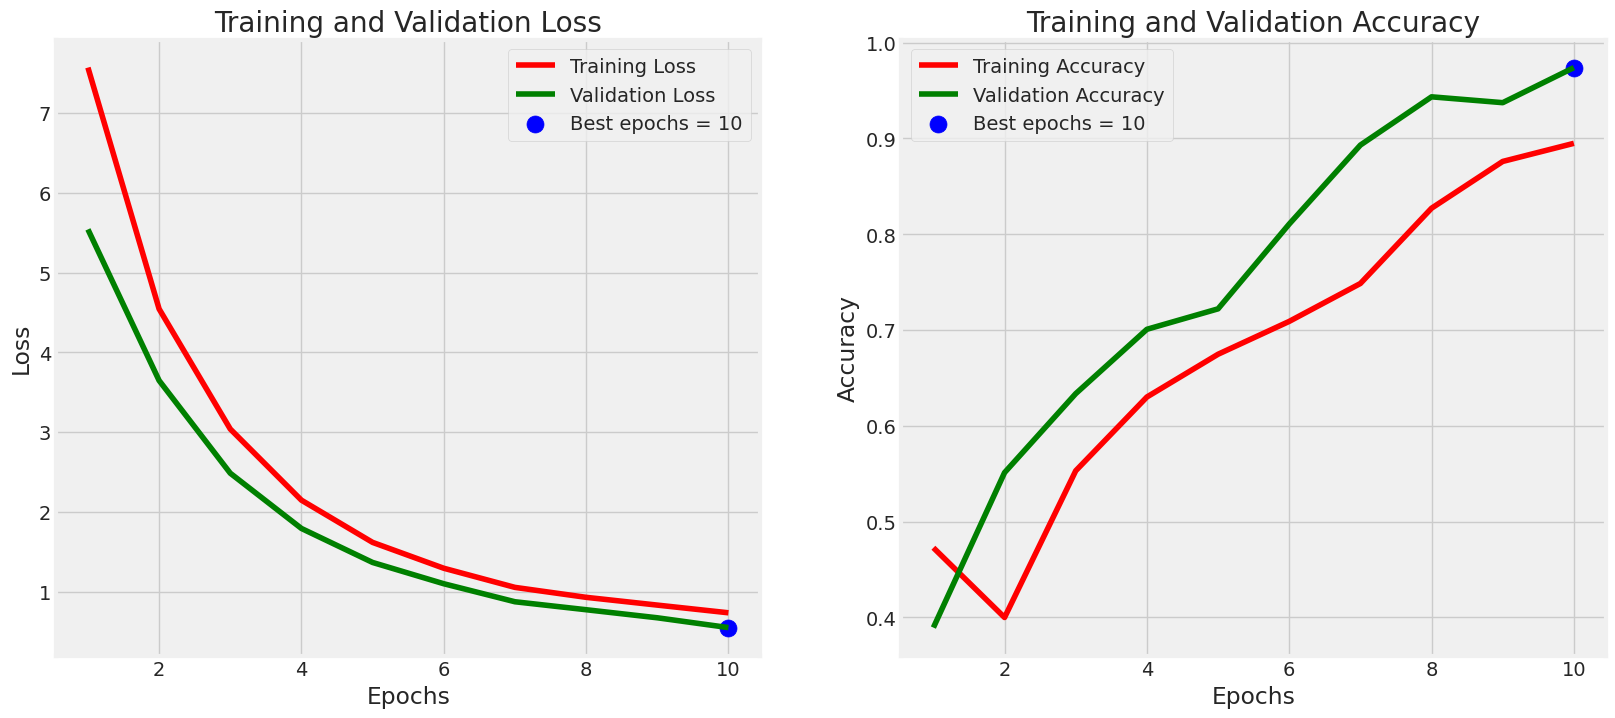

In [28]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [29]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9797 - loss: 0.5466
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9594 - loss: 0.5706
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9364 - loss: 0.5925
Train Loss:  0.5340129733085632
Train Accuracy:  0.98828125
--------------------
Validation Loss:  0.5467982888221741
Validation Accuracy:  0.9765625
--------------------
Test Loss:  0.5769079327583313
Test Accuracy:  0.9609375


In [30]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step


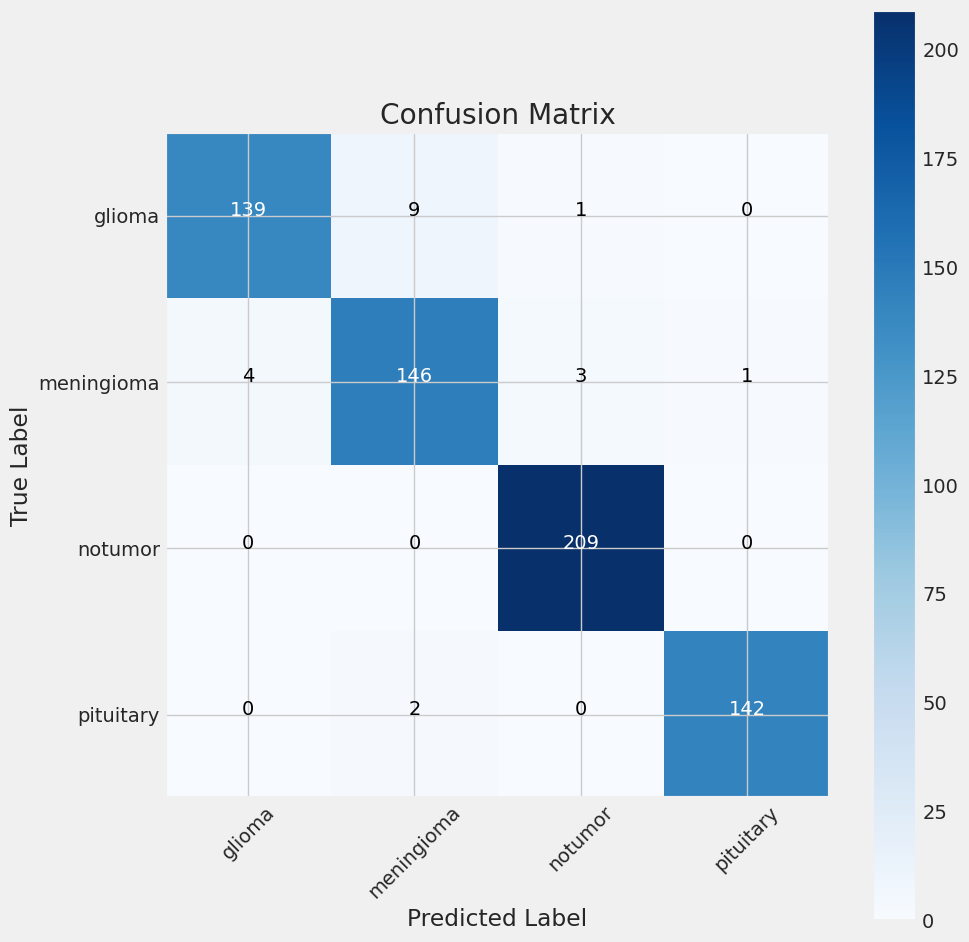

In [31]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [32]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       149
  meningioma       0.93      0.95      0.94       154
     notumor       0.98      1.00      0.99       209
   pituitary       0.99      0.99      0.99       144

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.97      0.97      0.97       656



## Saving Model

In [33]:
model.save("model.h5")

In [34]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

In [35]:
model = load_model('/content/model.h5', compile=False)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [37]:
gambar = tf.keras.preprocessing.image.load_img('/content/dataset/dataset/Testing/notumor/Te-noTr_0001.jpg', target_size=img_size)

In [38]:
input_arr = tf.keras.preprocessing.image.img_to_array(gambar)

In [39]:
input_arr = np.array([input_arr])
prediksi = model.predict(input_arr)
predicted_class = np.argmax(prediksi, axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


In [40]:
print(predicted_class)

[2]


In [41]:
print(classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [42]:
names = [classes[i] for i in predicted_class]
print(names)

['notumor']
